#### Setup

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 13.3 MB/s 
     |████████████████████████████████| 1.8 MB 12.9 MB/s 
     |████████████████████████████████| 596 kB 42.8 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 21.8 MB/s 
     |████████████████████████████████| 1.1 MB 34.2 MB/s 
     |████████████████████████████████| 352 kB 36.9 MB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 213 kB 47.6 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 47.6 MB 49.8 MB/s 


In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

#### Download the IMDB dataset

In [19]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

imdb_dataset = tf.keras.utils.get_file(
    fname="imdb.tar.gz",
    origin=url,
    untar=True,
    cache_dir=".",
    cache_subdir="",
)

In [20]:
train_dir = "/content/aclImdb/train/"
test_dir = "/content/aclImdb/test/"

BATCH_SIZE = 64
MAX_LENGTH = 256


# remove additiona dir: unsup in train
shutil.rmtree(train_dir + "unsup/")

train_dataset = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir, 
    labels='inferred', 
    label_mode='int',
    batch_size=BATCH_SIZE, 
    max_length=MAX_LENGTH, 
    shuffle=True, 
    seed=42,
    validation_split=0.2, 
    subset="training", 
) 

class_name = train_dataset.class_names

valid_dataset = tf.keras.utils.text_dataset_from_directory(
    directory=train_dir, 
    labels='inferred', 
    label_mode='int',
    batch_size=BATCH_SIZE, 
    max_length=MAX_LENGTH, 
    shuffle=True, 
    seed=42,
    validation_split=0.2, 
    subset="validation", 
) 

test_dataset = tf.keras.utils.text_dataset_from_directory(
    directory=test_dir, 
    labels='inferred', 
    label_mode='int',
    batch_size=BATCH_SIZE, 
    max_length=MAX_LENGTH, 
    shuffle=True, 
    seed=42,
) 


train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [21]:
class_name

['neg', 'pos']

In [22]:
for text, label in train_dataset.take(1):
    print(f"{label.numpy()[:5]}")
    print(f"{text.numpy()[:5]}")

[1 0 0 0 0]
[b"First of all, I liked very much the central idea of locating the '' intruders'', Others in the fragile Self, on various levels - mainly subconscious but sometimes more allegorical. In fact the intruders are omnipresent throughout the film : in the Swiss-Fr"
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situations, and so does t"
 b"After Harry Reems' teenage girlfriend is raped by Zebbedy Colt (The Night-Walker), Reems becomes despondent and consoles himself by having sex with some lesbians. Meanwhile, Colt, who carries a cane and dresses like a magician, rapes some more women. Event"
 b"It's boggles the mind how this movie was nominated for seven Oscars and won one. Not because it's abysmal or because given the collective credentials of the creative team behind it really ought to deser

#### Loading models from TensorFlow Hub

In [23]:
bert_model_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"
bert_tokenizer_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_model = hub.KerasLayer(bert_model_url)
tokenizer = hub.KerasLayer(bert_tokenizer_url)

In [24]:
tokenizer

In [25]:
sample = tf.constant(["This movie is awesome. Love it !"])

processed_sample = tokenizer(sample)

print(f"Processed sample keys: {processed_sample.keys()}")

print(f"input_mask: {processed_sample['input_mask']}")
print(f"input_mask size: {processed_sample['input_mask'].shape}")
print(f"input_word_ids: {processed_sample['input_word_ids']}")
print(f"input_type_ids: {processed_sample['input_type_ids']}")

Processed sample keys: dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])
input_mask: [[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
input_mask size: (1, 128)
input_word_ids: [[  101  2023  3185  2003 12476  1012  2293  2009   999   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
   

In [26]:
bert_output = bert_model(processed_sample)

print(f"Outputs: {bert_output.keys()}")
print(f"pooled_output: {bert_output['pooled_output'].shape}")
print(f"sequence_output: {bert_output['sequence_output'].shape}")


Outputs: dict_keys(['pooled_output', 'default', 'sequence_output', 'encoder_outputs'])
pooled_output: (1, 512)
sequence_output: (1, 128, 512)


#### Define your model

In [34]:
def build_model():
    bert_model = hub.KerasLayer(bert_model_url, trainable=True, name="bert_model")
    tokenizer = hub.KerasLayer(bert_tokenizer_url, name='tokenizer')
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    tokenized = tokenizer(text_input)
    outputs = bert_model(tokenized)
    pooled_output = outputs['pooled_output']
    output = tf.keras.layers.Dense(1, activation=None, name="classifier")(pooled_output)
    model = tf.keras.Model(text_input, output)

    return model

In [35]:
model = build_model()

model_output = model(sample)

print(tf.sigmoid(model_output))

tf.Tensor([[0.09168365]], shape=(1, 1), dtype=float32)


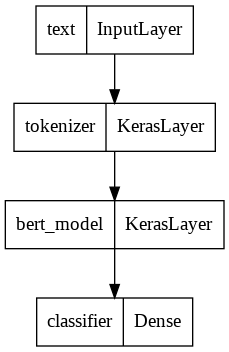

In [36]:
tf.keras.utils.plot_model(model)

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tokenizer (KerasLayer)         {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

#### Model training

In [31]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00003)
metrics = tf.keras.metrics.BinaryAccuracy()

In [39]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [40]:
history = model.fit(
    x=train_dataset,
    validation_data=valid_dataset,
    epochs=5,
)

Epoch 1/5
313/313 [==============================] - 285s 891ms/step - loss: 0.5161 - binary_accuracy: 0.6693 - val_loss: 0.4604 - val_binary_accuracy: 0.7792
Epoch 2/5
313/313 [==============================] - 274s 876ms/step - loss: 0.3964 - binary_accuracy: 0.8084 - val_loss: 0.4624 - val_binary_accuracy: 0.7868
Epoch 3/5
313/313 [==============================] - 268s 858ms/step - loss: 0.3049 - binary_accuracy: 0.8617 - val_loss: 0.4886 - val_binary_accuracy: 0.7930
Epoch 4/5
313/313 [==============================] - 270s 861ms/step - loss: 0.2366 - binary_accuracy: 0.8992 - val_loss: 0.5367 - val_binary_accuracy: 0.7896
Epoch 5/5
313/313 [==============================] - 268s 857ms/step - loss: 0.1800 - binary_accuracy: 0.9263 - val_loss: 0.5701 - val_binary_accuracy: 0.7870


#### Evaluate the model

In [41]:
model.evaluate(test_dataset)

391/391 [==============================] - 163s 416ms/step - loss: 0.5646 - binary_accuracy: 0.7918


[0.5646409392356873, 0.7917600274085999]

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


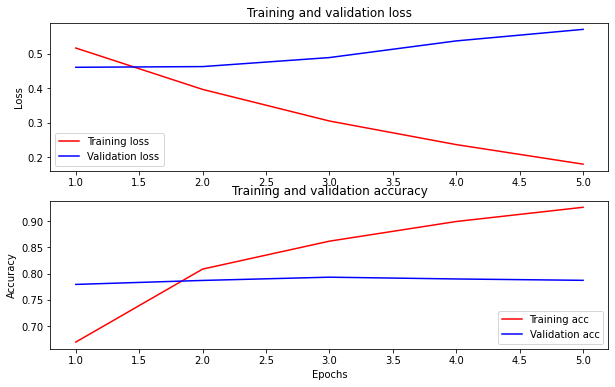

In [42]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#### Export for inference

In [43]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

In [44]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [45]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999682
input: The movie was great!           : score: 0.995349
input: The movie was meh.             : score: 0.301350
input: The movie was okish.           : score: 0.003706
input: The movie was terrible...      : score: 0.002417

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999682
input: The movie was great!           : score: 0.995349
input: The movie was meh.             : score: 0.301349
input: The movie was okish.           : score: 0.003706
input: The movie was terrible...      : score: 0.002417

